# SINVAD Experiments - Preliminary

This notebook provides outlines on experiments performed for the preliminary study (Section 3.3 of paper). It contains code that generates results similar to those presented in Figure 2-6 of the paper.

## Step 0. Preparation

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import scipy
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sa.model import MnistClassifier, EasyClassifier
from vae.model import VAE

In [2]:
img_size = 28*28*1
torch.no_grad()
vae_model_path = './vae/models/MNIST_EnD.pth'
classifier_model_path = './sa/models/MNIST_conv_classifier.pth'

In [3]:
vae = VAE(img_size = 28*28, h_dim = 1600, z_dim = 400)
vae.load_state_dict(torch.load(vae_model_path))
vae.eval()
vae.cuda()

classifier = MnistClassifier(img_size = img_size)
classifier.load_state_dict(torch.load(classifier_model_path))
classifier.eval()
classifier.cuda()
print("models loaded")

models loaded


In [4]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=False)
train_data_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=False)
test_data_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)
print("Data loader ready")

Data loader ready


### Preprocessing to calculate Surprise Adequacy

In [5]:
sa_layer = 7
layer_dim = 512

In [6]:
# get KDE used for LSA calculation
all_ats = torch.zeros(0, layer_dim)
for i, (x, x_class) in enumerate(train_data_loader):
    x = x.cuda()
    ats = classifier.at_by_layer(x, sa_layer).detach()
    all_ats = torch.cat([all_ats, ats.cpu()], dim=0)
all_ats = all_ats.transpose(0, 1).numpy()
rem_cols = np.std(all_ats, axis=1) < 0.6
ref_all_ats = all_ats[~rem_cols]
ref_all_ats = ref_all_ats[:100]
print(ref_all_ats.shape)
our_kde = gaussian_kde(ref_all_ats)

def calc_lsa(at, kde):
    return -kde.logpdf(at)

def calc_img_lsa(img):
    pr_at = classifier.at_by_layer(img, sa_layer).detach()
#     pr_at = classifier.up2lyr2(img).detach()
    pr_at = pr_at.cpu().numpy().transpose()
    pr_at = pr_at[~rem_cols][:100]
    return calc_lsa(pr_at, our_kde)

(100, 60000)


In [7]:
lsas = []
for i, (x, x_class) in enumerate(test_data_loader):
    if i > 100: break
    lsas.append(calc_img_lsa(x.cuda()))
#     print(i)
print(f'maximum lsa in test dataset: {max(lsas)}')
print(f'minimum lsa in test dataset: {min(lsas)}')

maximum lsa in test dataset: [196.30572451]
minimum lsa in test dataset: [112.29167027]


## Step 1. Optimizing Images

Images are optimized to have a certain surprise adequacy value. The point of this experiment is to show that the choice of representation is influential in how coherent the final result is, motivating the use of VAEs in SINVAD. The code in this step corresponds to Figure 2 in the paper. 

### Optimizing with raw pixel representation

Original Random Image


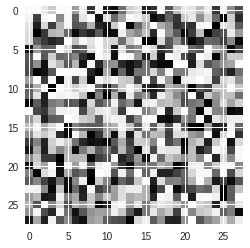

In [8]:
# generate random pixel image
print('Original Random Image')
pix_rand_img = np.random.randn(28, 28)
plt.imshow(np.tanh(pix_rand_img))

In [9]:
pix_rand_img_tensor = torch.Tensor(pix_rand_img).cuda().view(-1, 1, 28, 28)
pr_at = classifier.at_by_layer(pix_rand_img_tensor, sa_layer).detach()
pr_at = pr_at.cpu().numpy().transpose()
pr_at = pr_at[~rem_cols][:100]
print('lsa of random image:', calc_lsa(pr_at, our_kde)[0])

lsa of random image: 229.9683377016408


In [10]:
# fitness function
def loss(sa, obj = -10):
    return abs(sa - obj)

In [11]:
# optimization (a form of hill climbing)
prev_sa = calc_img_lsa(pix_rand_img_tensor)
target_sa = 111
prev_loss = loss(prev_sa, target_sa)
opt_img = pix_rand_img_tensor.clone()

opt_epoch_num = 3
last_diff_prop = 2.
for e_idx in range(opt_epoch_num):
    update_num = 0
    print(f'-----epoch {e_idx} start-----')
    for i in range(28):
        for j in range(28):
            img_copy = opt_img.clone()
            img_copy[:, :, i, j] = img_copy[:, :, i, j] + last_diff_prop*torch.randn(1).cuda()
            new_sa = calc_img_lsa(img_copy)
            new_loss = loss(new_sa, target_sa)
            if prev_loss > new_loss:
                opt_img = img_copy
                prev_loss = new_loss
                prev_sa = new_sa
                update_num += 1
                print('\r'*100, end='')
                print(f'new_sa: {new_sa[0]:.1f}', end='')
    print(f'\n# of updates: {update_num}')
    if (update_num == 0 or prev_loss < 0.01): break
    print(f'-----epoch {e_idx} over-----')
    last_diff_prop *= 0.5

-----epoch 0 start-----
new_sa: 128.1
# of updates: 179
-----epoch 0 over-----
-----epoch 1 start-----
new_sa: 125.9
# of updates: 128
-----epoch 1 over-----
-----epoch 2 start-----
new_sa: 125.6
# of updates: 90
-----epoch 2 over-----


Target SA 111, Actual SA 125.6


(-0.5, 27.5, 27.5, -0.5)

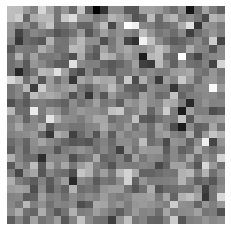

In [12]:
print(f'Target SA {target_sa}, Actual SA {new_sa[0]:.1f}')
plt.imshow(opt_img.view(28, 28).detach().cpu())
plt.axis('off')

### Optimizing with VAE latent space (SINVAD)

Original Random Image


/home/sungmin/Documents/dlTestGen/dlenv/lib/python3.6/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


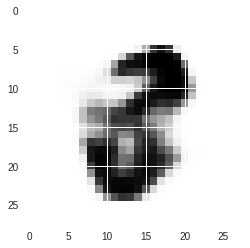

In [13]:
b_size = 1
rand_norm_v = torch.randn(b_size, 400).cuda()
vae_rand_imgs = vae.decode(rand_norm_v)
print('Original Random Image')
plt.imshow(vae_rand_imgs[0].view(1, 1, 28, 28)[0][0].detach().cpu())

In [14]:
# helper functions
def calc_z_lsa(z):
    vae_img = vae.decode(z).view(-1, 1, 28, 28)
    return calc_img_lsa(vae_img)

def loss(sa, obj = -10):
    return abs(sa - obj)

def z_to_img(z):
    return vae.decode(z).detach()

In [15]:
print('initial SA:', calc_z_lsa(rand_norm_v))

initial SA: [138.23754883]


In [16]:
# same optimization process as above
prev_sa = calc_z_lsa(rand_norm_v)
target_sa = 111
prev_loss = loss(prev_sa, target_sa)
opt_z = rand_norm_v.clone()
z_dim = 400

last_diff_prop = 5.
opt_epoch_num = 3
for e_idx in range(opt_epoch_num):
    last_epoch_z = opt_z
    update_num = 0
    print(f'-----epoch {e_idx} start-----')
    for i in range(z_dim):
        z_copy = opt_z.clone()
        z_copy[:, i] = z_copy[:, i] + last_diff_prop*torch.randn(1).cuda()
        new_sa = calc_z_lsa(z_copy)
        new_loss = loss(new_sa, obj=target_sa)
        if prev_loss > new_loss:
            opt_z = z_copy
            prev_loss = new_loss
            prev_sa = new_sa
            update_num += 1
            print('\r'*100, end='')
            print(f'new_sa: {new_sa[0]:.4f}', end='')
        if prev_loss < 0.01: break
    print(f'\n# of updates: {update_num}')
    print(f'change though opt: {torch.sum(torch.abs(last_epoch_z - opt_z))}')
    last_diff_prop = max(torch.sum(torch.abs(last_epoch_z - opt_z))/update_num, update_num/z_dim)
    if (update_num == 0 or prev_loss < 0.01): break

-----epoch 0 start-----
new_sa: 123.9971
# of updates: 123
change though opt: 362.7850341796875
-----epoch 1 start-----
new_sa: 116.8613
# of updates: 149
change though opt: 305.752197265625
-----epoch 2 start-----
new_sa: 114.5472
# of updates: 133
change though opt: 185.51837158203125


Target SA 111, Actual SA 114.5


(-0.5, 27.5, 27.5, -0.5)

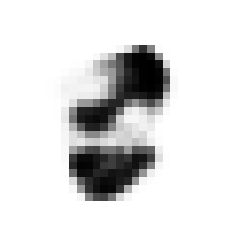

In [17]:
print(f'Target SA {target_sa}, Actual SA {new_sa[0]:.1f}')
plt.imshow(z_to_img(opt_z).view(28, 28).detach().cpu())
plt.axis('off')

## Step 2. Interpolation

Using two randomly sampled images, we qualitatively observe the interpolation qualities of the representations. This code corresponds to Figure 5 in the paper. 

In [18]:
# sample a random pair of images
tc = (4, 9)
for i, (x, x_class) in enumerate(train_data_loader):
    x = x.cuda()
    img1 = x[0:1]
    img2 = x[1:2]
    if x_class[0] == tc[0] and x_class[1] == tc[1]:
        break

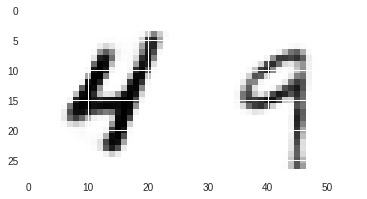

In [19]:
# get intermediate vectors, show reconstruction (without noise)
enc1, _ = vae.encode(img1.view(-1, img_size))
enc2, _ = vae.encode(img2.view(-1, img_size))
rec_img1 = vae.decode(enc1).view(1, 1, 28, 28)
rec_img2 = vae.decode(enc2).view(1, 1, 28, 28)
showoff_img = torch.cat([rec_img1, rec_img2], dim=3)
plt.imshow(showoff_img[0, 0].detach().cpu())

(-0.5, 167.5, 55.5, -0.5)

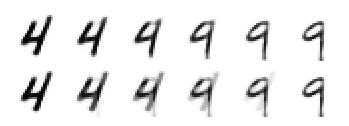

In [20]:
# interpolation results (change `interval` to control degree of interpolation)
interval = 5
raw_images = []
vae_images = []
for i in range(interval+1):
    recomb_enc = (1-(i/interval))*enc1 + (i/interval)*enc2
    recomb_img = vae.decode(recomb_enc).view(1, 1, 28, 28)
    vae_images.append(recomb_img)
    raw_recomb_img = (1-(i/interval))*rec_img1 + (i/interval)*rec_img2
    raw_images.append(raw_recomb_img.view(1, 1, 28, 28))
vae_showoff_img = torch.cat(vae_images, dim=3)
raw_showoff_img = torch.cat(raw_images, dim=3)
showoff_img = torch.cat([vae_showoff_img, raw_showoff_img], dim=2)
plt.imshow(showoff_img[0, 0].detach().cpu())
plt.axis('off')